# Modelagem de Tópicos com LDA, NMF e SVD
Neste notebook, vamos explorar a modelagem de tópicos utilizando três algoritmos diferentes: Latent Dirichlet Allocation (LDA), Non-negative Matrix Factorization (NMF), e Singular Value Decomposition (SVD). Nosso objetivo é encontrar o melhor valor de \( k \) (número de tópicos) para cada um desses algoritmos, utilizando métricas específicas a cada um. Por fim, vamos comparar os resultados de cada modelo.


In [6]:
# Libraries

import warnings

warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import KFold
from ulteis import preprocess

# Preparar dados 
Por essa parte ser repetitiva não iremos detalhar muito, em resumo aplicamos preprocessamento já definido e uma vez que usaremos a biblioteca Gensim teremos que preparar os dados para se adequar ao padrão que a biblioteca aceita.

In [7]:
bbc_df = pd.read_csv("../data/bbc_data.csv")

text_df = bbc_df["data"].apply(preprocess)
labels_df = bbc_df["labels"]

# Lista com todas as palavras de todos os textos
texts_topics = [word.split() for word in text_df] 
# Criando um dicionário, associa cada palavra a um id
id2word = corpora.Dictionary(texts_topics)
# Lista de tuplas (id, frequência) para todas as palavras.
corpus = [id2word.doc2bow(text) for text in texts_topics]

# Exemplo
print(corpus[222], "\n")
# Exemplo mapeado
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:222]])

[(4, 2), (39, 1), (40, 2), (67, 2), (70, 1), (85, 4), (90, 2), (95, 1), (106, 1), (112, 2), (119, 1), (133, 1), (138, 2), (142, 4), (143, 3), (148, 1), (153, 4), (161, 4), (168, 1), (175, 4), (178, 11), (185, 1), (194, 1), (233, 1), (244, 1), (246, 1), (250, 1), (258, 1), (272, 1), (276, 1), (281, 1), (282, 2), (289, 1), (296, 1), (299, 3), (304, 1), (319, 1), (327, 1), (334, 1), (343, 1), (348, 1), (352, 1), (363, 1), (371, 1), (377, 1), (384, 4), (386, 1), (387, 1), (388, 3), (398, 1), (399, 2), (400, 2), (401, 2), (402, 2), (408, 1), (424, 1), (426, 1), (427, 2), (430, 1), (431, 2), (436, 1), (437, 4), (441, 1), (478, 1), (483, 1), (509, 2), (512, 1), (514, 1), (524, 1), (600, 1), (623, 1), (632, 2), (634, 1), (674, 2), (723, 1), (736, 1), (749, 5), (776, 1), (830, 1), (848, 1), (859, 1), (893, 1), (894, 1), (909, 1), (922, 1), (923, 1), (928, 1), (934, 1), (957, 1), (959, 1), (993, 5), (994, 1), (995, 5), (996, 3), (1011, 1), (1013, 1), (1034, 1), (1040, 1), (1083, 1), (1099, 1), (

# Modelagem de Tópicos com LDA

O **Latent Dirichlet Allocation (LDA)** é um modelo probabilístico que identifica tópicos em um conjunto de documentos, assumindo que cada documento é composto por uma mistura de tópicos, e cada tópico é uma distribuição de palavras.

### Coerência de Tópicos
Mede a qualidade dos tópicos verificando se as palavras dentro de cada tópico fazem sentido juntas. Tópicos com alta coerência têm palavras semanticamente relacionadas, tornando os tópicos mais interpretáveis.

### Perplexidade
Avalia o quão bem o modelo se ajusta aos dados, com valores mais baixos indicando um melhor ajuste. No entanto, pode não refletir diretamente a qualidade interpretável dos tópicos, exigindo um equilíbrio com a coerência.


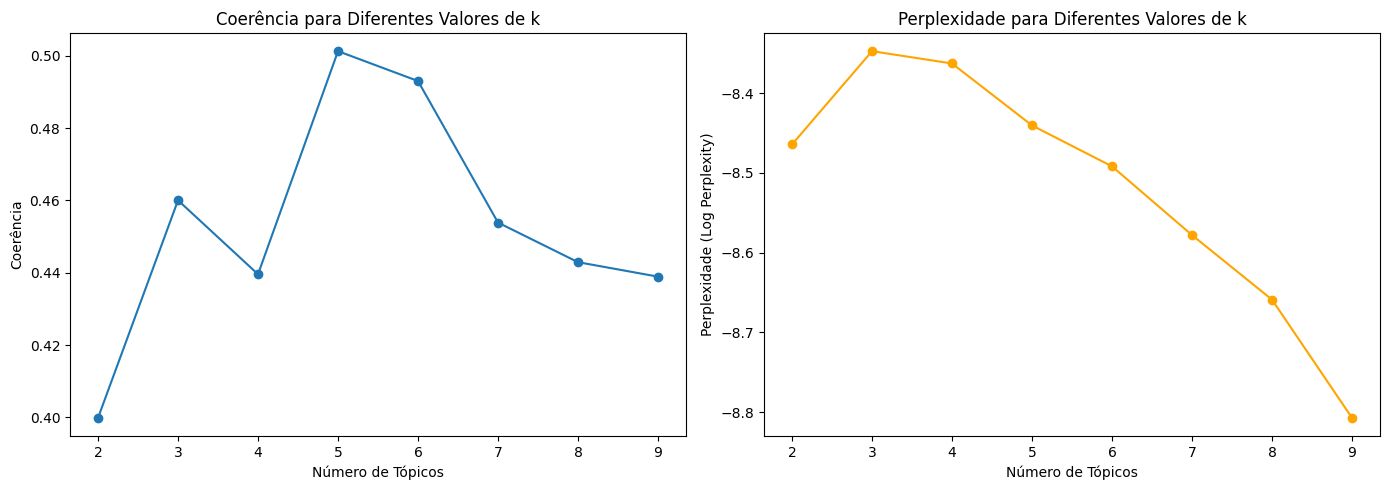

In [8]:
# Função para treinar o modelo e computar valores de correlação e perplexi
def compute_coherence_values(dictionary, corpus, texts, list_range):
    coherence_values = []
    perplexity_values = []
    
    for num_topics in list_range:
        # Treinando o modelo LDA
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, 
                         update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        
        # Calculando a coerência
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        # Calculando a perplexidade
        perplexity_values.append(model.log_perplexity(corpus))
    
    return coherence_values, perplexity_values


# Plotagem 
list_range = [2,3,4,5,6,7,8,9]
coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts_topics, list_range=list_range)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot coherence values
ax1.plot(list_range, coherence_values, marker='o')
ax1.set_title('Coerência para Diferentes Valores de k')
ax1.set_xlabel('Número de Tópicos')
ax1.set_ylabel('Coerência')

# Plot perplexity values
ax2.plot(list_range, perplexity_values, marker='o', color='orange')
ax2.set_title('Perplexidade para Diferentes Valores de k')
ax2.set_xlabel('Número de Tópicos')
ax2.set_ylabel('Perplexidade (Log Perplexity)')

# Show the plots
plt.tight_layout()
plt.show()

## Análise dos Resultados do LDA
Com base no gráfico de coerência, podemos selecionar o valor de \( k \) = 5 que maximiza a coerência dos tópicos. Também consideraremos a **perplexidade** para refinar a escolha de \( k \) = 5.


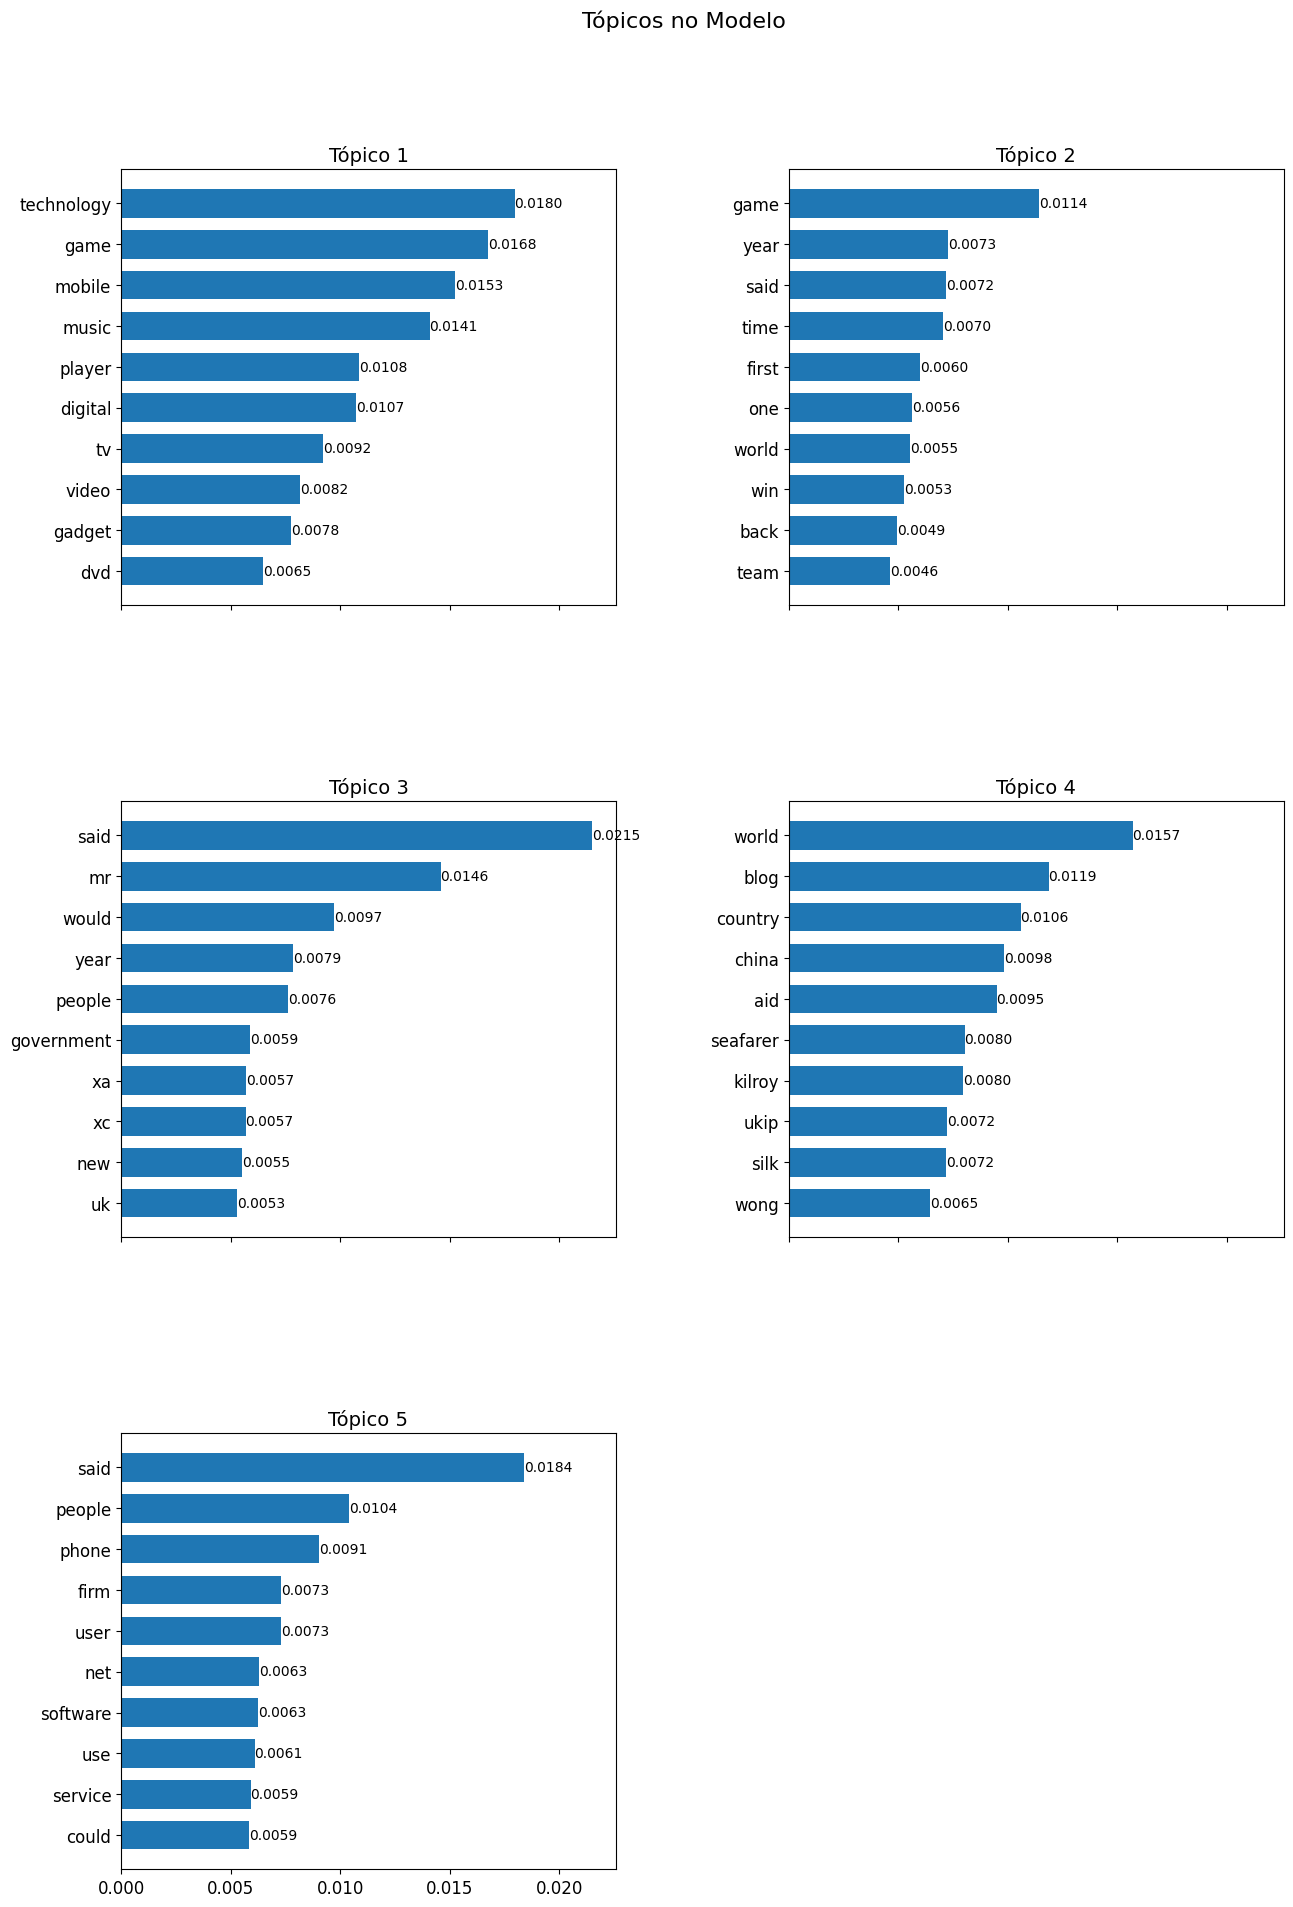

In [9]:
# Função para exibir as palavras mais relevante de cada topico
def plot_lda_topics(model, num_topics, num_words=10):
    fig, axes = plt.subplots(3, 2, figsize=(15, 20), sharex=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_topics:
            # Obtendo as palavras e os pesos para o tópico
            topic_words = model.show_topic(i, num_words)
            words, weights = zip(*topic_words)
            
            # Criando o gráfico de barras horizontais
            ax.barh(words, weights, height=0.7)
            ax.set_title(f'Tópico {i+1}', fontsize=14)
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=12)
            
            # Adicionando os valores de pesos nas barras
            for j, (weight, word) in enumerate(zip(weights, words)):
                ax.text(weight, j, f'{weight:.4f}', va='centeF

    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.35, hspace=0.45)
    plt.suptitle(f'Tópicos no Modelo', fontsize=16)
    plt.show()

# Treinando o modelo LDA com k=5
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=100, 
                         update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# Plotando os tópicos com os pesos
plot_lda_topics(lda, 5)

## Análise de cada topico com base nas palavras exibidas

### Tópico 1:
- **Palavras-chave**: technology, game, mobile, music, player, digital, tv, video, gadget, dvd
- **Interpretação**: Este tópico parece estar relacionado à **tecnologia e entretenimento**. As palavras indicam dispositivos móveis, música, tecnologia digital e jogos, sugerindo que o tópico cobre temas de tecnologia de consumo.

### Tópico 2:
- **Palavras-chave**: game, year, said, time, first, one, world, win, back, team
- **Interpretação**: Este tópico parece estar relacionado a **esportes ou competições**. Palavras como "game", "win", "team" sugerem um foco em competições esportivas ou de jogos, possivelmente eventos anuais ou competições.

### Tópico 3:
- **Palavras-chave**: said, mr, would, year, people, government, xa, xc, new, uk
- **Interpretação**: Este tópico parece ter um foco em **notícias políticas** ou **governamentais**. Palavras como "government", "mr", "said", "people", "UK" sugerem que o tópico trata de discussões políticas ou notícias de governança.

### Tópico 4:
- **Palavras-chave**: world, blog, country, china, aid, seafarer, kilroy, ukip, silk, wong
- **Interpretação**: Este tópico parece abordar **questões globais** ou **relações internacionais**, com palavras como "world", "country", "china", "aid", e "seafarer". Pode estar relacionado a blogs ou discussões sobre política global e comércio.

### Tópico 5:
- **Palavras-chave**: said, people, phone, firm, user, net, software, use, service, could
- **Interpretação**: Este tópico provavelmente trata de **tecnologia e telecomunicações**. Palavras como "phone", "net", "software", "service" sugerem discussões sobre o uso de dispositivos móveis e serviços de internet.


# Modelagem de Tópicos com NMF

O **Non-negative Matrix Factorization (NMF)** é um algoritmo de decomposição matricial que fatoriza a matriz de documentos em duas outras matrizes: uma que representa os tópicos e outra que representa a associação entre documentos e tópicos. Todos os valores gerados são não-negativos, o que facilita a interpretação dos tópicos.

Para validar o melhor número de tópicos \( k \), vamos utilizar duas métricas principais:

### 1. Sparsidade (Sparsity)
A **sparsidade** mede a quantidade de valores zero nas matrizes resultantes do NMF. Quanto maior a sparsidade, mais esparsa será a matriz, o que significa que cada tópico será composto por poucas palavras e cada documento estará associado a poucos tópicos.

**Interpretação**: Tópicos com alta sparsidade são mais facilmente interpretáveis, pois cada tópico será composto por um número reduzido de palavras-chave. Isso facilita a compreensão do que o tópico representa.

**Objetivo**: O valor ideal de \( k \) deve maximizar a sparsidade, mantendo os tópicos úteis e interpretáveis.

### 2. Erro de Reconstrução (Reconstruction Error)
O **erro de reconstrução** mede a diferença entre a matriz original de documentos e a matriz reconstruída a partir dos tópicos gerados pelo NMF.

**Interpretação**: Um erro de reconstrução menor significa que a decomposição NMF está capturando bem as informações presentes na matriz original. No entanto, valores muito baixos de erro podem resultar em overfitting (muitos tópicos irrelevantes).

**Objetivo**: O valor de \( k \) ideal deve minimizar o erro de reconstrução, garantindo que o modelo capture a estrutura dos dados sem gerar tópicos desnecessários.

Ao balancear essas duas métricas, podemos encontrar o número \( k \) de tópicos que gera a melhor decomposição, com tópicos interpretáveis e uma boa reconstrução da matriz original.


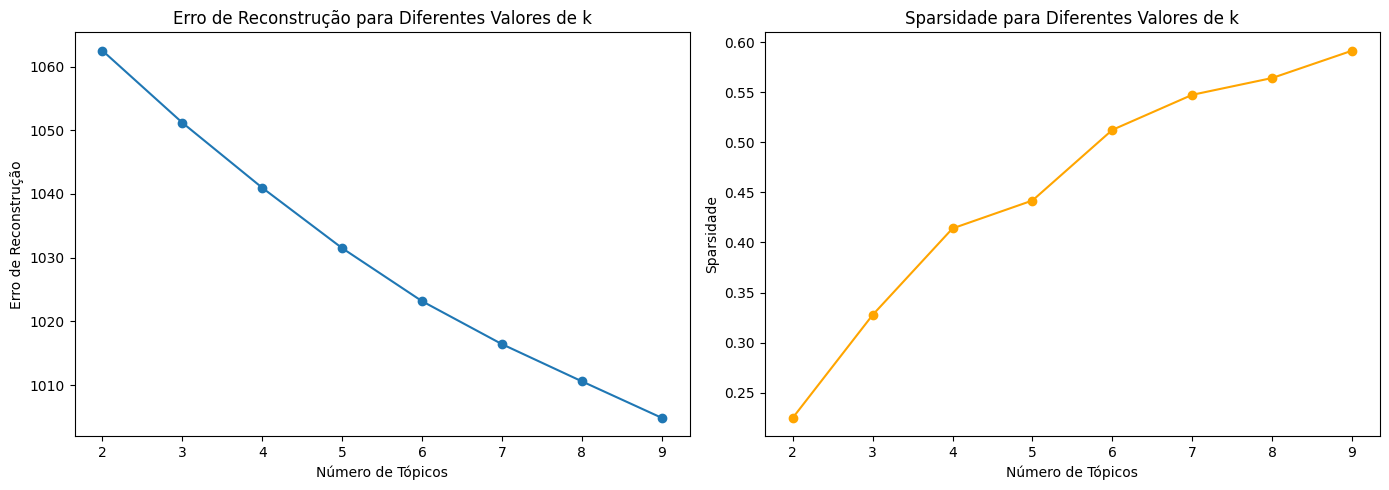

In [10]:
cv = CountVectorizer()
X = cv.fit_transform(text_df)

# Função para calcular o erro de reconstrução e a sparsidade
def compute_nmf_metrics(X, list_range):
    reconstruction_errors = []
    sparsity_values = []
    
    for num_topics in list_range:
        # Treinando o modelo NMF com Scikit-learn
        nmf = NMF(n_components=num_topics, random_state=100, init='nndsvd', max_iter=200)
        W = nmf.fit_transform(X)
        H = nmf.components_
        
        # Calculando o erro de reconstrução
        reconstruction_error = np.linalg.norm(X - np.dot(W, H), 'fro')
        reconstruction_errors.append(reconstruction_error)
        
        # Calculando a sparsidade
        sparsity = (np.count_nonzero(W) + np.count_nonzero(H)) / (W.size + H.size)
        sparsity_values.append(1 - sparsity)  # Invertendo para valores maiores representarem maior sparsidade
    
    return reconstruction_errors, sparsity_values

# Lista de valores de k (número de tópicos)
list_range = [2, 3, 4, 5, 6, 7, 8, 9]

# 2. Calcular os valores de erro de reconstrução e sparsidade
reconstruction_errors, sparsity_values = compute_nmf_metrics(X, list_range)

# 3. Plotar os gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plotar Erro de Reconstrução
ax1.plot(list_range, reconstruction_errors, marker='o')
ax1.set_title('Erro de Reconstrução para Diferentes Valores de k')
ax1.set_xlabel('Número de Tópicos')
ax1.set_ylabel('Erro de Reconstrução')

# Plotar Sparsidade
ax2.plot(list_range, sparsity_values, marker='o', color='orange')
ax2.set_title('Sparsidade para Diferentes Valores de k')
ax2.set_xlabel('Número de Tópicos')
ax2.set_ylabel('Sparsidade')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

## Análise dos Resultados do NMF
Com base nas observações dos gráficos:𝑘 = 5 ou 𝑘 = 6 pode ser um bom valor para o número de tópicos. Isso ocorre porque, a partir desses valores, a redução no erro de reconstrução começa a se estabilizar, e a sparsidade aumenta a um nível que ainda permite uma boa interpretabilidade dos tópicos.


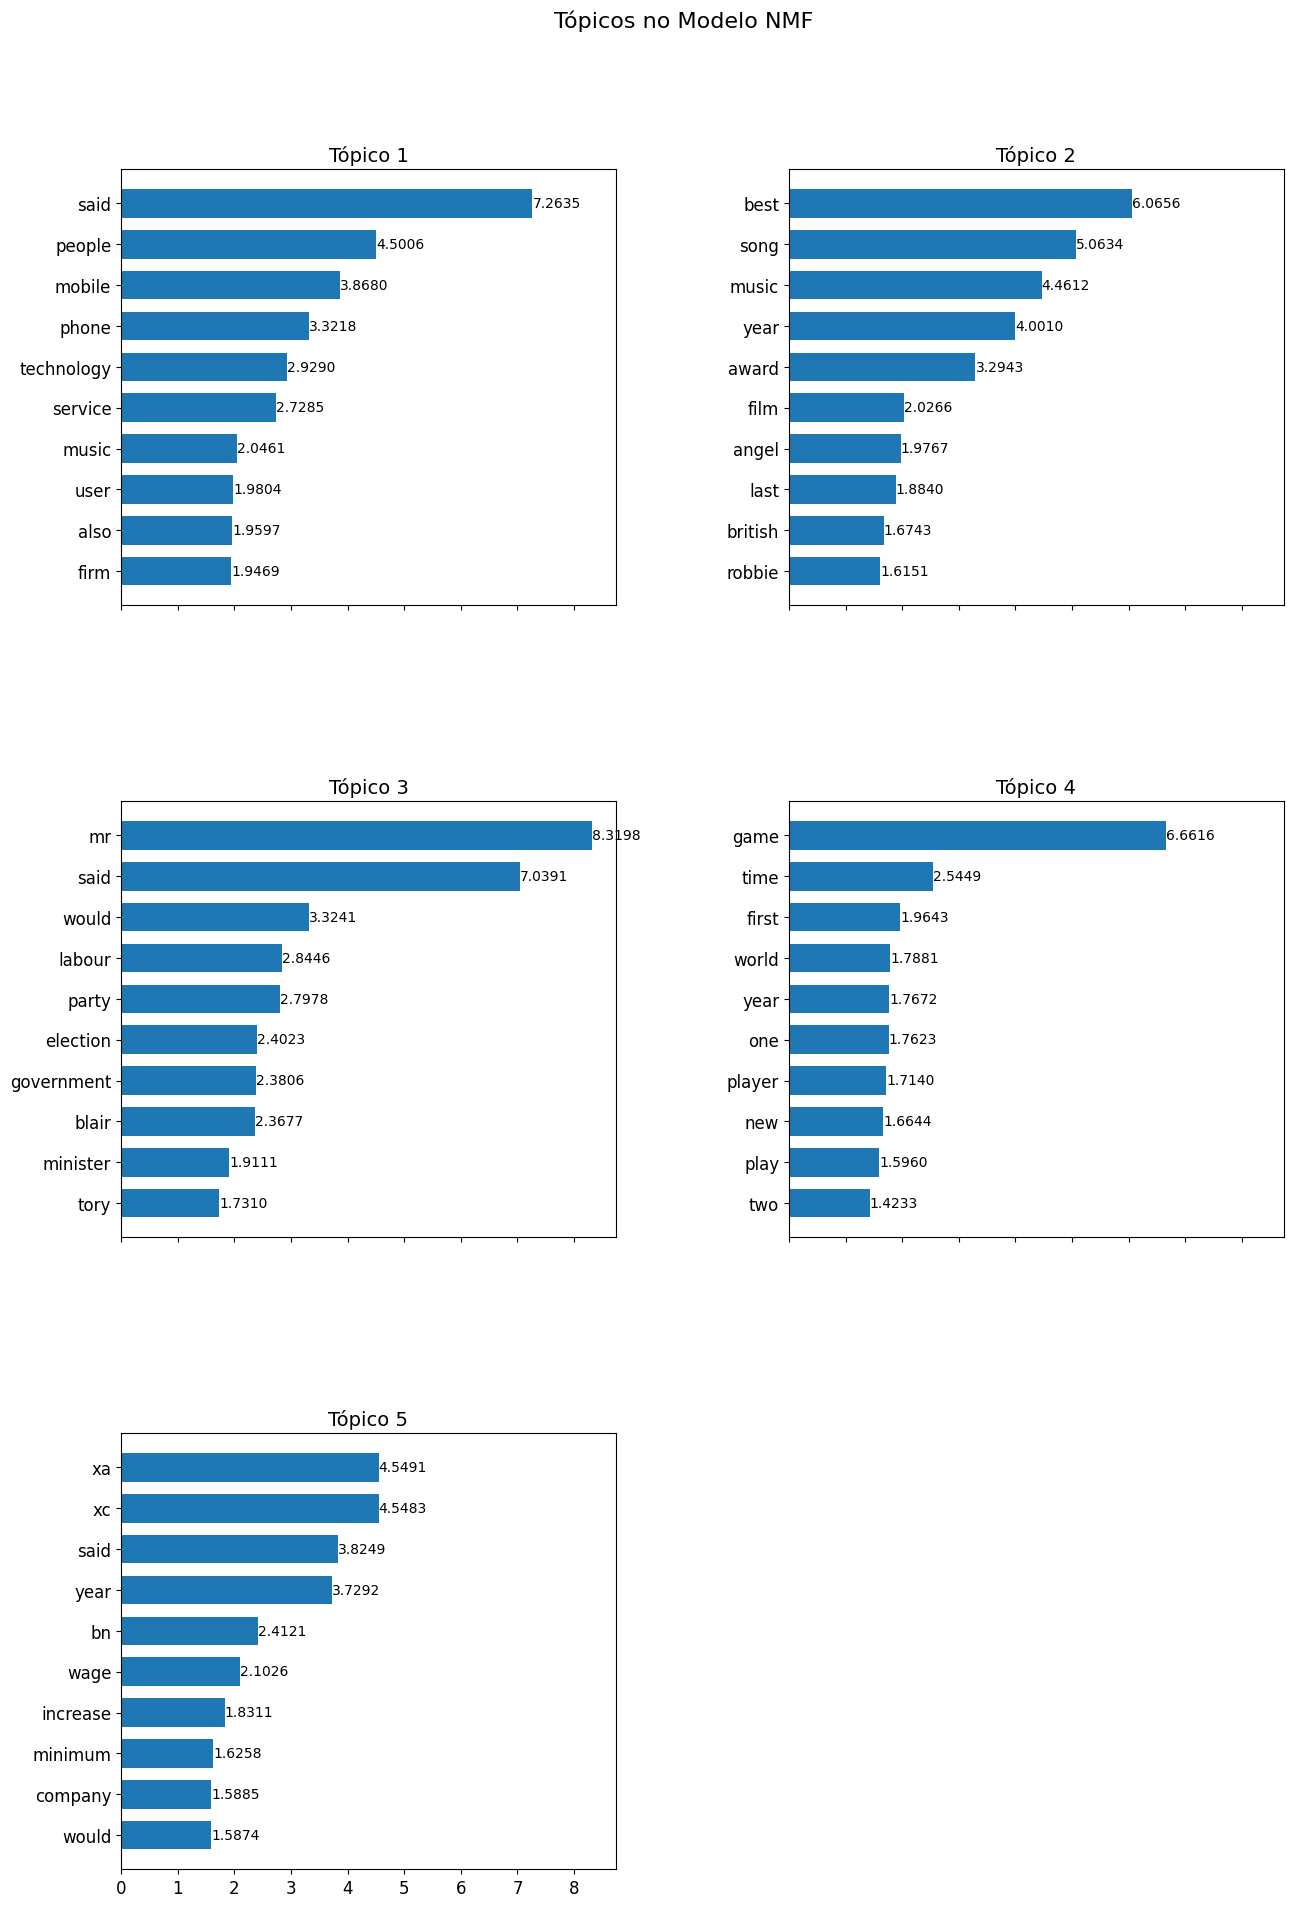

In [11]:
# Função para exibir os tópicos
def plot_nmf_topics(model, feature_names, num_words=10):
    num_topics = model.components_.shape[0]
    fig, axes = plt.subplots(3, 2, figsize=(15, 20), sharex=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_topics:
            # Obtendo os índices das palavras mais importantes para cada tópico
            top_words_idx = model.components_[i].argsort()[-num_words:][::-1]
            top_words = [feature_names[idx] for idx in top_words_idx]
            top_weights = model.components_[i][top_words_idx]

            # Plotando os tópicos
            ax.barh(top_words, top_weights, height=0.7)
            ax.set_title(f'Tópico {i+1}', fontsize=14)
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=12)
            
            # Adicionando os valores de pesos nas barras
            for j, (weight, word) in enumerate(zip(top_weights, top_words)):
                ax.text(weight, j, f'{weight:.4f}', va='center')  # Mostrando os pesos com 4 casas decimais
        else:
            ax.axis('off')

    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.35, hspace=0.45)
    plt.suptitle(f'Tópicos no Modelo NMF', fontsize=16)
    plt.show()

# Chamando a função para plotar os tópicos
feature_names = cv.get_feature_names_out()  # Obtendo os nomes das palavras do CountVectorizer ou TfidfVectorizer
nmf = NMF(n_components=5, random_state=100, init='nndsvd', max_iter=200)
nmf.fit_transform(X)
plot_nmf_topics(nmf, feature_names, num_words=10)



## Análise de cada topico com base nas palavras exibidas

### Tópico 1:
- **Palavras-chave**: disse, pessoas, celular, telefone, tecnologia, serviço, música, usuário, também, empresa
- **Interpretação**: Esse tópico parece abordar **tecnologia de consumo e serviços**. Palavras como "celular", "telefone", "usuário" e "tecnologia" indicam que o foco é em dispositivos tecnológicos e como as pessoas (usuários) interagem com esses serviços e produtos. "Música" e "empresa" também podem sugerir uma combinação de produtos digitais (streaming, por exemplo) e o setor de serviços associado.

### Tópico 2:
- **Palavras-chave**: melhor, canção, música, ano, prêmio, filme, anjo, último, britânico, Robbie
- **Interpretação**: Este tópico claramente está relacionado à **indústria do entretenimento**, particularmente música e cinema. Palavras como "canção", "música", "prêmio" e "filme" sugerem discussões sobre premiações e produções artísticas. "Robbie" provavelmente se refere ao cantor Robbie Williams, o que fortalece a ideia de que o tópico abrange o setor de música britânica e filmes.

### Tópico 3:
- **Palavras-chave**: sr., disse, seria, trabalho (ou Partido Trabalhista), partido, eleição, governo, Blair, ministro, conservador
- **Interpretação**: Este tópico está relacionado à **política**, particularmente no Reino Unido. A menção a "Blair" (Tony Blair, ex-primeiro-ministro), "Partido Trabalhista", "eleição" e "governo" sugere discussões políticas. As palavras "conservador" e "ministro" reforçam que o tópico trata de debates entre partidos e figuras políticas importantes no cenário britânico.

### Tópico 4:
- **Palavras-chave**: jogo, tempo, primeiro, mundo, ano, um, jogador, novo, jogar, dois
- **Interpretação**: Esse tópico está relacionado ao **mundo dos jogos e competições**. Palavras como "jogo", "jogador", "mundo" e "jogar" indicam que o tópico está discutindo atividades relacionadas a competições, videogames ou esportes em geral. A presença de palavras como "primeiro", "ano" e "novo" sugere um foco em eventos ou campeonatos recentes ou futuros.

### Tópico 5:
- **Palavras-chave**: xa, xc, disse, ano, bn, salário, aumento, mínimo, empresa, seria
- **Interpretação**: Esse tópico parece estar relacionado a **questões trabalhistas e econômicas**. "Salário", "aumento", "mínimo" e "empresa" indicam discussões sobre remuneração, política salarial e questões econômicas. As palavras "xa", "xc" e "bn" podem ser siglas de organizações ou termos específicos, possivelmente de negociações trabalhistas.


# Modelagem de Tópicos com SVD
O **Singular Value Decomposition (SVD)** é uma técnica de fatoração matricial. Vamos utilizar a **variância explicada** e **Erro de reconstrução** para definir o número ideal de componentes \( k \).


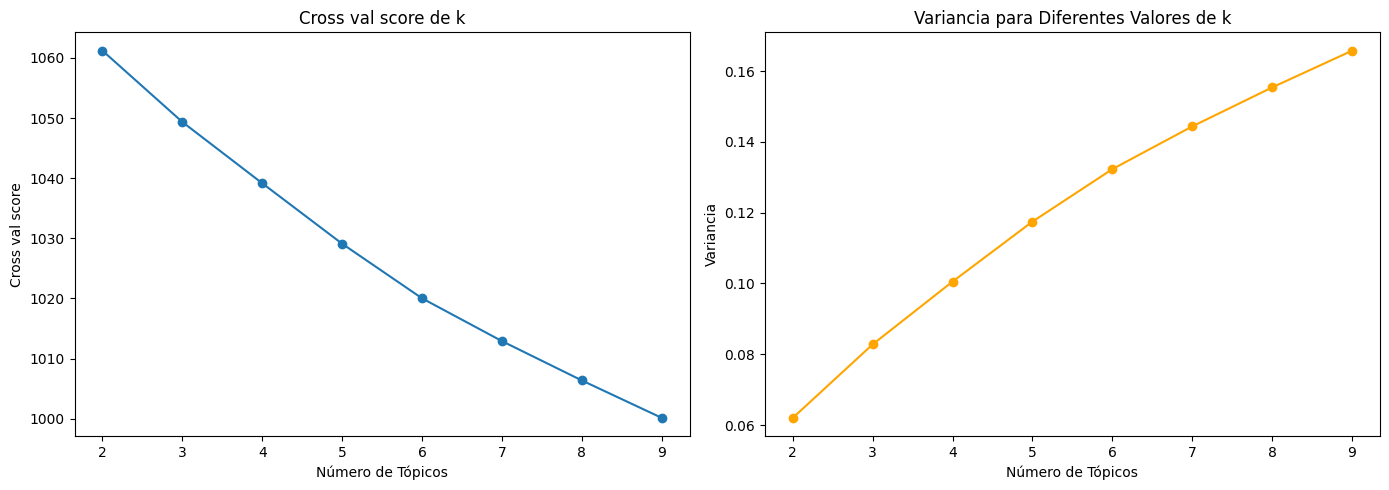

In [13]:
# Função para calcular o erro de reconstrução e a sparsidade
def compute_svd_metrics(X, list_range):
    reconstruction_errors = []
    variance_scores = []
    
    # K-fold
    kf = KFold(shuffle=True)
    
    for i in list_range:
        svd = TruncatedSVD(n_components=i)
        X_transformed = svd.fit_transform(X)
        
        # Calculando a variância explicada (soma das variâncias explicadas de todas as componentes)
        variance_explained = np.sum(svd.explained_variance_ratio_)
        variance_scores.append(variance_explained)
        
        # Calculando o erro de reconstrução (reprojetando o dado original)
        X_reconstructed = np.dot(X_transformed, svd.components_)
        reconstruction_error = np.linalg.norm(X - X_reconstructed, 'fro')
        reconstruction_errors.append(reconstruction_error)
    
    return reconstruction_errors, variance_scores

# Lista de valores de k (número de tópicos)
list_range = [2, 3, 4, 5, 6, 7, 8, 9]

# 2. Calcular os valores de variancia e cross val score
reconstruction_errors, variance_scores = compute_svd_metrics(X, list_range)

# 3. Plotar os gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plotar cross val score 
ax1.plot(list_range, reconstruction_errors, marker='o')
ax1.set_title('Cross val score de k')
ax1.set_xlabel('Número de Tópicos')
ax1.set_ylabel('Cross val score')

# Plotar Sparsidade
ax2.plot(list_range, variance_scores, marker='o', color='orange')
ax2.set_title('Variancia para Diferentes Valores de k')
ax2.set_xlabel('Número de Tópicos')
ax2.set_ylabel('Variancia')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

## Análise dos Resultados do SVD
Os graficos obtidos acima não nos ajudam muito a definir o melhor valor de K, visto que aparentão ser bastante uniformes, mas para seguir a analise vamos tomar k = 5.

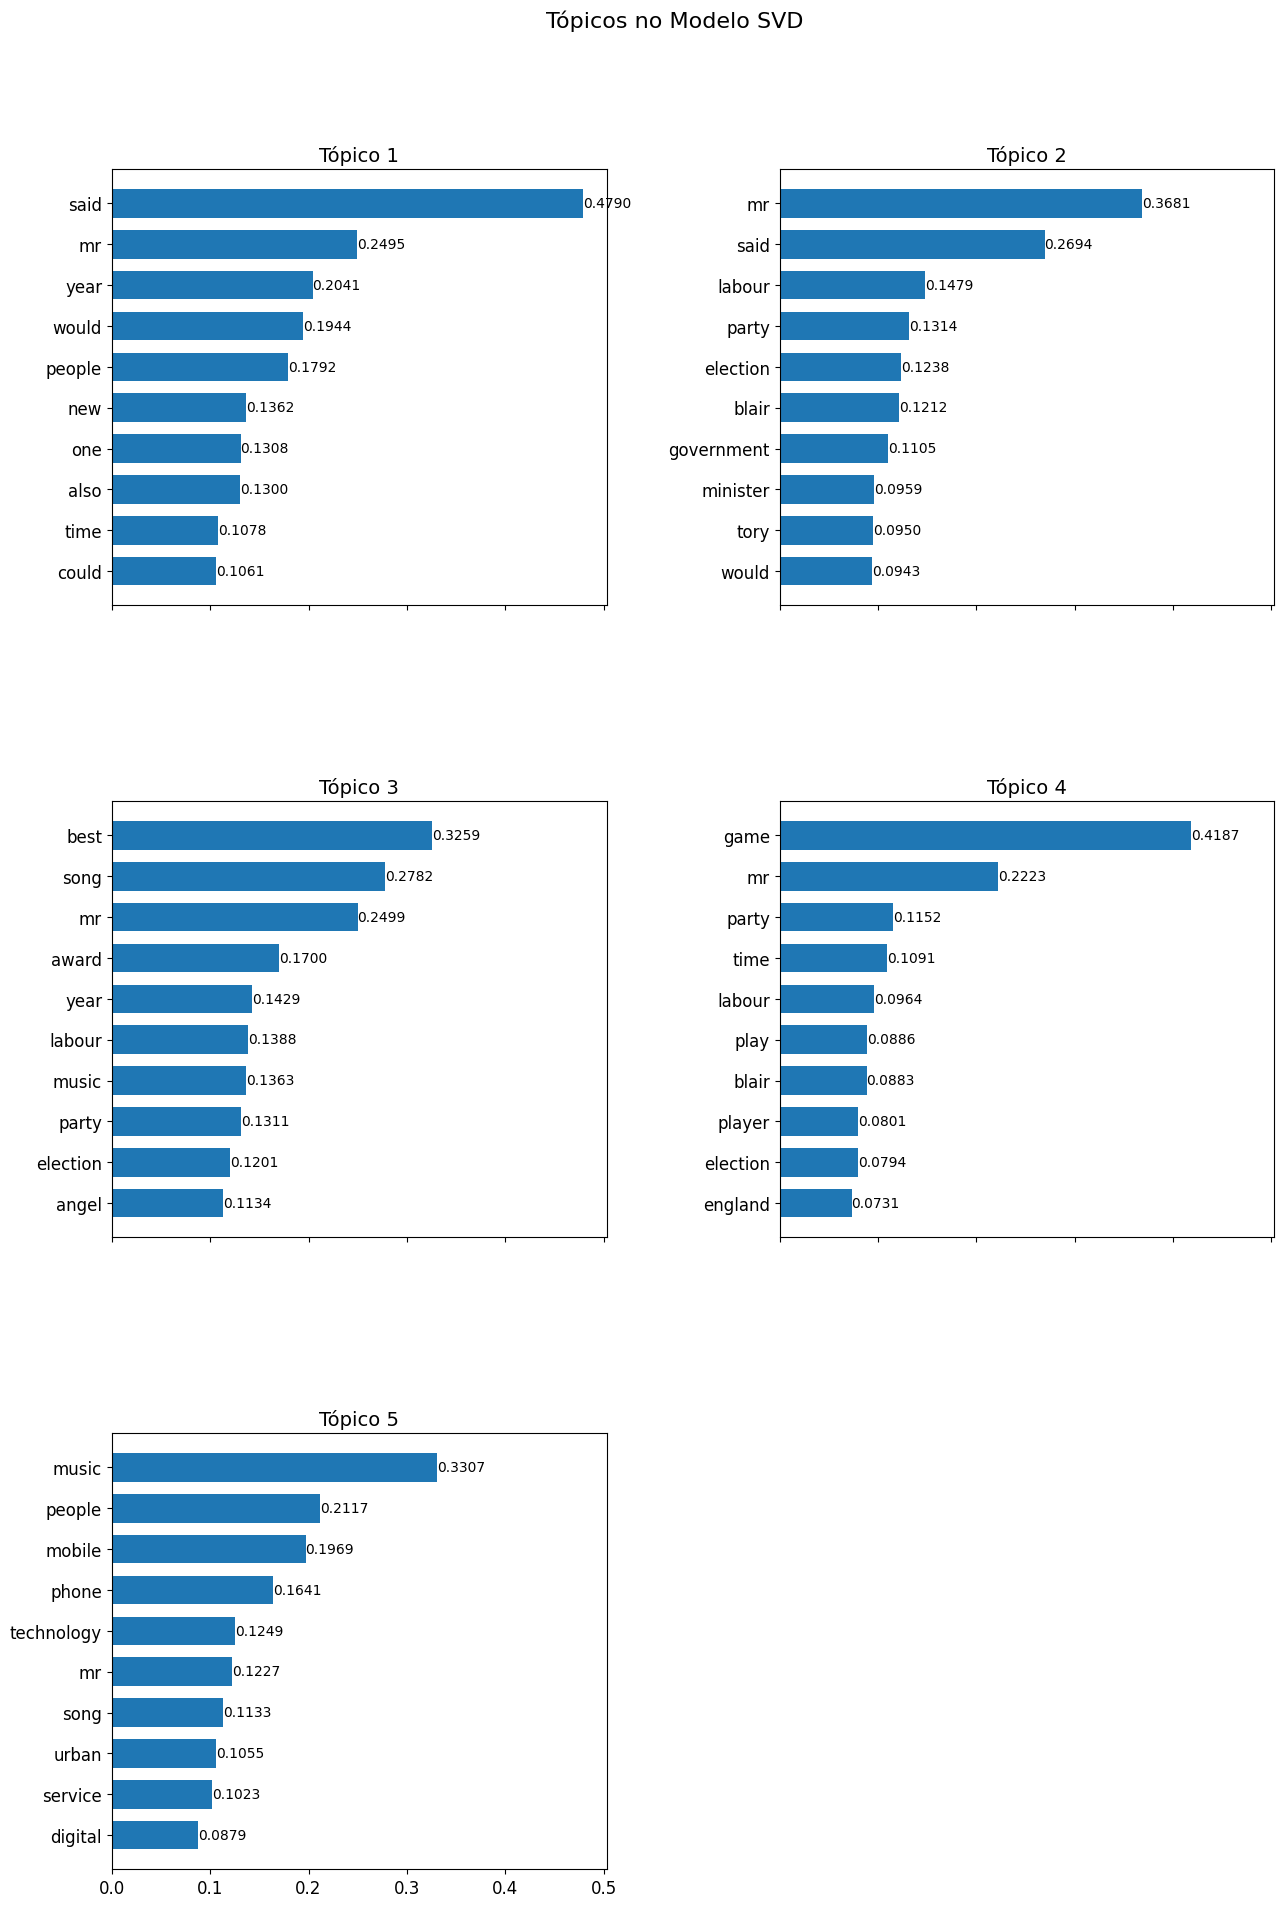

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Função para exibir os tópicos do SVD
def plot_svd_topics(model, feature_names, num_words=10):
    num_topics = model.components_.shape[0]
    fig, axes = plt.subplots(3, 2, figsize=(15, 20), sharex=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_topics:
            # Obtendo os índices das palavras mais importantes para cada componente/tópico
            top_words_idx = model.components_[i].argsort()[-num_words:][::-1]
            top_words = [feature_names[idx] for idx in top_words_idx]
            top_weights = model.components_[i][top_words_idx]

            # Plotando os tópicos
            ax.barh(top_words, top_weights, height=0.7)
            ax.set_title(f'Tópico {i+1}', fontsize=14)
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=12)

            # Adicionando os valores de pesos nas barras
            for j, (weight, word) in enumerate(zip(top_weights, top_words)):
                ax.text(weight, j, f'{weight:.4f}', va='center')  # Mostrando os pesos com 4 casas decimais
        else:
            ax.axis('off')

    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.35, hspace=0.45)
    plt.suptitle(f'Tópicos no Modelo SVD', fontsize=16)
    plt.show()

# Chamando a função para plotar os tópicos
feature_names = cv.get_feature_names_out()  # Obtendo os nomes das palavras do CountVectorizer ou TfidfVectorizer
svd = TruncatedSVD(n_components=5, random_state=100)
svd.fit_transform(X)
plot_svd_topics(svd, feature_names, num_words=10)


## Análise de cada topico com base nas palavras exibidas

### Tópico 1:
- **Palavras-chave**: said, mr, year, would, people, new, one, also, time, could
- **Interpretação**: O tópico está relacionado a **notícias ou declarações públicas**, focando em figuras proeminentes e eventos ao longo do tempo. Há menções frequentes a pessoas, anos e possibilidades, indicando discussões sobre **mudanças sociais ou políticas**.

### Tópico 2:
- **Palavras-chave**: mr, said, labour, party, election, blair, government, minister, tory, would
- **Interpretação**: Claramente relacionado à **política no Reino Unido**, mencionando o **Partido Trabalhista**, o **Partido Conservador** e figuras políticas como **Tony Blair**. O foco está em **discussões eleitorais e governamentais**.

### Tópico 3:
- **Palavras-chave**: best, song, music, year, award, labour, party, election, angel
- **Interpretação**: Combina **entretenimento e política**, com foco em **premiações e a indústria musical**, além de referências a **debates eleitorais** e eventos culturais com relevância política.

### Tópico 4:
- **Palavras-chave**: game, mr, party, time, labour, play, blair, player, election, england
- **Interpretação**: Mistura temas de **jogos e política**, com referências a competições e discussões políticas britânicas. Possivelmente trata de **eventos esportivos com impacto político**.

### Tópico 5:
- **Palavras-chave**: music, people, mobile, phone, technology, mr, song, urban, service, digital
- **Interpretação**: Foca em **tecnologia e telecomunicações**, incluindo o impacto de dispositivos móveis e serviços digitais, com menções à **música** e **serviços urbanos**.


# Comparação Final e Conclusão
Após a modelagem de tópicos utilizando os algoritmos **LDA**, **NM** e **SVD**, observamos que o **LDA** (Latent Dirichlet Allocation) destacou-se significativamente no quesito de semântica dos tópicos. O **LDA** mostrou uma maior coerência entre as palavras dentro de cada tópico, sugerindo agrupamentos de termos que fazem mais sentido juntos e facilitando a interpretação dos temas extraídos dos dados.

